# Brief description of the problem and data (5 pts) 

Briefly describe the challenge problem and CNN. Describe the size, dimension, 
structure, etc., of the data. 


The goal of this project is to create a machine learning algorithm to classify histpathologic samples as cancerous or benign. The model will be based on Convolution Neural Networks, which are popularly used for image classification. They function through the use of many layers (input, multiple hidden, and an output layer), wherein weights and thresholds capture local and global information of an image as it passes through the layers.

This approach is appropriate for this task because the dataset provided has 220,000 images to train on and 57,500 images to test. The images are RGB images, with nxn pixels; 3xnxn dimensions, and with (seemingly) abstract shapes. Each image however, has been categorized into malignant or benign, and the planned model will be able to pick up the important features to accurately classify the test dataset. 

This model is adapted from https://www.kaggle.com/code/trca7468msdscu/complete-beginner-s-guide-eda-keras-lb-0-93/edit/run/188562670 
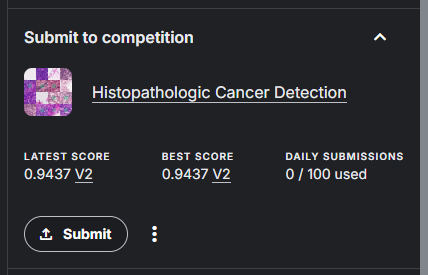

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import cv2
from glob import glob 
import pandas as pd
import gc

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D

from tqdm import tqdm_notebook,trange, tqdm
# from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

keras.backend.set_floatx('float32')
keras.backend.set_image_data_format('channels_last')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

os.listdir('../input/histopathologic-cancer-detection')


['sample_submission.csv', 'train_labels.csv', 'test', 'train']

Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)

Show a few visualizations like histograms. Describe any data cleaning procedures. 
Based on your EDA, what is your plan of analysis? 

In [2]:
path = '/kaggle/input/histopathologic-cancer-detection'
train_path = path + '/train'
test_path = path + '/test'

df = pd.DataFrame({'path':glob(os.path.join(train_path,'*.tif'))})
df['id'] = df.path.map(lambda x: x.split('/')[-1].split('.')[0])
labels = pd.read_csv(path+'/train_labels.csv')
df = df.merge(labels, on='id')


df_0 = df[df['label']==0]
df_1 = df[df['label']==1]

First, to investigate if there are any obvious differences between the positive and negative samples, we can display samples of the dataset. Displayed are 6 random images of each category alongside their respective labels. To an untrained eye, it is nearly impossible to reason why the sample images have been labeled accordingly. In fact, there are  similarities betweeen the categories, and also many disimilarities within each category. Therefore, a computational approach to evaluate the dataset must be a lot more methodical and intricate.

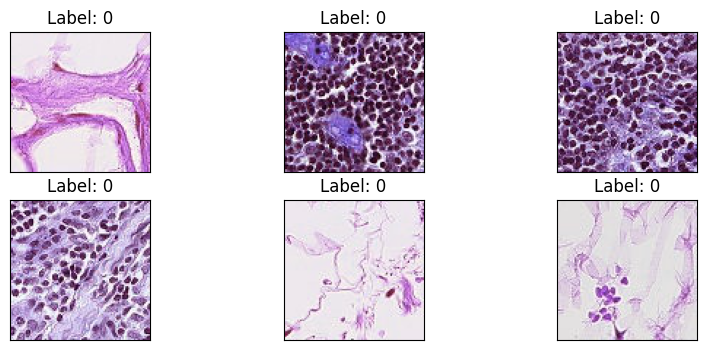

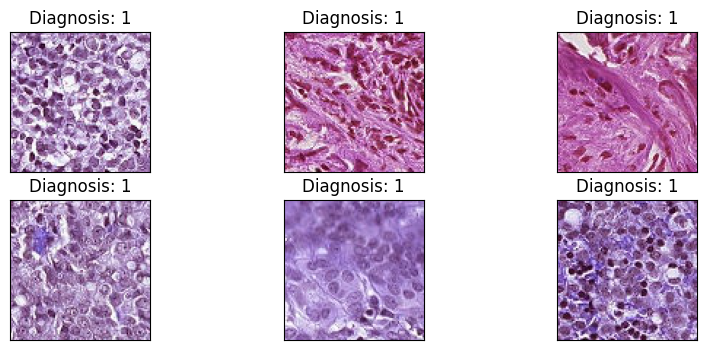

In [3]:
np.random.seed(42)
n_imgs = 500

fig = plt.figure(figsize=(10,4))
for i, path in enumerate(np.random.randint(0,n_imgs,6)):
    ax = fig.add_subplot(2, 6//2, i+1, xticks=[], yticks=[])
    plt.imshow(cv2.imread(df_0.iloc[path]['path']))
    ax.set_title('Label: ' + str(df_0.iloc[i]['label']))

fig = plt.figure(figsize=(10,4))
for i, path in enumerate(np.random.randint(0,n_imgs,6)):
    ax = fig.add_subplot(2, 6//2, i+1, xticks=[], yticks=[])
    plt.imshow(cv2.imread(df_1.iloc[path]['path']))
    ax.set_title('Diagnosis: ' + str(df_1.iloc[i]['label']))

To continue our EDA, we split the first 500 RGB images of both malignant and benign images into their red, green, and blue channels. The benign (or 0 classified) are colored as gray, and the malignant (or 1 classified) are colored to display differences in spectra. Histograms are plotted and it is evident for all 3 channels that there are unique spectra which could be used to separate malignant from benign cross sections.

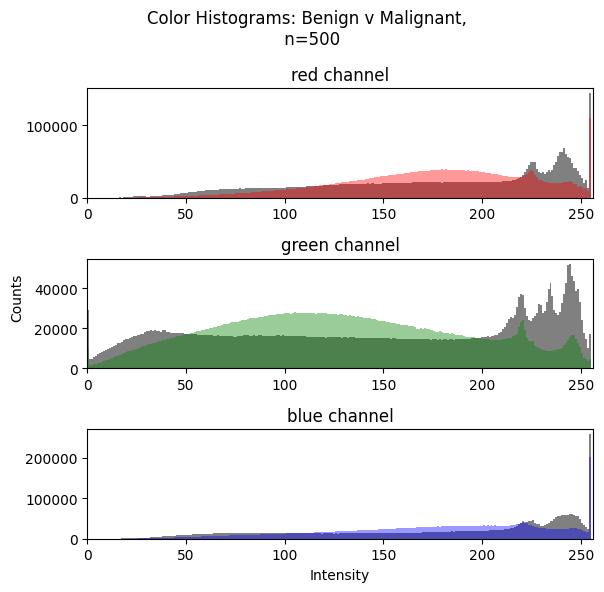

In [4]:
fig, ax = plt.subplots(3, figsize=(6,6))
colors = ['red', 'green', 'blue']
ch_0 = {key : [] for key in colors}
ch_1 = {key : [] for key in colors}

for j in range(n_imgs):
    image_0 = cv2.imread(df_0.iloc[j]['path'])
    image_1 = cv2.imread(df_1.iloc[j]['path'])
    
    for i, color in enumerate(colors):
        ch_0[color].extend(image_0[:,:,i].flatten())
        ch_1[color].extend(image_1[:,:,i].flatten())
    
for i, color in enumerate(colors):
    ax[i].hist(ch_0[color], bins=256, density=False, color='gray')
    ax[i].hist(ch_1[color], bins=256, density=False, color=color, alpha=0.4)
    ax[i].set_xlim([0,256])
    ax[i].title.set_text(color + ' channel')
    
plt.suptitle('Color Histograms: Benign v Malignant, \n n=' + str(n_imgs))
fig.text(0, 0.5, 'Counts', va='center', rotation='vertical')
plt.xlabel('Intensity')
plt.tight_layout()
plt.show()

Clearly there are discernable differences in the individual color distributions for the red, green, and blue channels. It has also been shown in past submissions that parsing out the information from each channel proves to be a valid approach for developing accurate prediction models. 

However, when there are three color channels, each channel spans values from 0 - 256, across 96x96 pixels per image, and with tens of thousands of images, the amount of information quickly grows and could reach a critical maximum limit. 

We can actually consolidate the RGB channels into a grayscale which effectively reduces the amount of data to handle by 1/3. This is simply done by following the formula:

***Y= 0.299×R + 0.587×G + 0.114×B***

(Reference: https://docs.opencv.org/2.4/modules/imgproc/doc/miscellaneous_transformations.html#void%20cvtColor%28InputArray%20src,%20OutputArray%20dst,%20int%20code,%20int%20dstCn%29) 

To make it even easier, cv2 has a simple method to read color images as grayscale so we don't have to go through the hassle of converting the images ourselves.

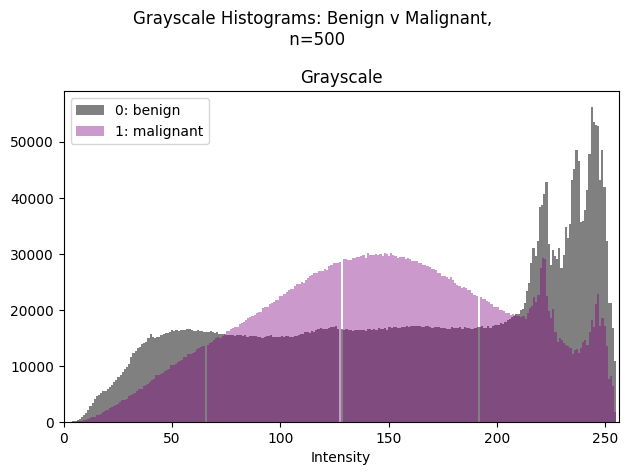

33556

In [5]:
ch_0 = []
ch_1 = []

for j in range(n_imgs):
    image_0 = cv2.imread(df_0.iloc[j]['path'], cv2.IMREAD_GRAYSCALE)
    image_1 = cv2.imread(df_1.iloc[j]['path'], cv2.IMREAD_GRAYSCALE)
    
    ch_0.extend(image_0.flatten())
    ch_1.extend(image_1.flatten())

plt.hist(ch_0, bins=256, density=False, color='gray')
plt.hist(ch_1, bins=256, density=False, color='purple', alpha=0.4)

plt.xlim(0,256)
plt.legend(['0: benign', '1: malignant'])
plt.title('Grayscale')    
plt.suptitle('Grayscale Histograms: Benign v Malignant, \n n=' + str(n_imgs))
fig.text(0, 0.5, 'Counts', va='center', rotation='vertical')
plt.xlabel('Intensity')
plt.tight_layout()
plt.show()

del ch_0, ch_1
gc.collect()

Model Architecture (25 pts)

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 



CNNs have been proven to be very promising for images in particular because of the kernel approach; regular Neural Networks use an algebraic equation rather than a matrix of information and thus do not capture enough information. The procedure of CNN can be compared to human vision and thus are well suited for image classifcation. CNNs learn directly from data without manual over-engineering, through the use of kernels it hones in on key features to parse out information and as result reduces dimensionality. 

More specifically this method is well suited for image analysis because it uses multiple layers of pattern recognition to evaluate a picture. It approaches an image of interest by scanning across the entire NxN figure and slides a smaller filter (kernel) to extract "necessary" information. This process identifies small geometric features such as lines, curves, and shapes (local features), and bigger features more relative to size and space (global features). Essentially, local features provide specific detail while global features provide contextual detail, and together accrue enough data to accurately identify key elements to accurately classify images.

In a CNN, there are different approaches to consider but CNNs typically will have convolution layers, pooling layers, and finally a fully connected layer. The convolution layers will 

In [6]:
def load_gray(N,df):
    """ This function has been adapted from the original to load the images as a grayscale instead of RGB
    """
    X = np.zeros([N,96,96],dtype=np.uint8) 
    y = np.squeeze(df['label'].values)[0:N]
    for i, row in tqdm(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'], cv2.IMREAD_GRAYSCALE)
    return X,y

In [7]:
# Load N images
# N=10000
N = int(np.floor(df["path"].size))

X,y = load_gray(N=N,df=df) 

training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

#shuffle
np.random.seed(42) 
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

n_train = int(N*0.8)

x_train = X[:n_train]
y_train = y[:n_train]

x_test = X[n_train:N]
y_test = y[n_train:N]

100%|██████████| 220025/220025 [34:11<00:00, 107.25it/s]


In [8]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

#conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

#conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model.add(Dense(1, activation = "sigmoid"))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=50)
model.evaluate(x_test, y_test)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1739816551.962826     107 service.cc:145] XLA service 0x79b1f4004b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739816551.962902     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


   7/3521 ━━━━━━━━━━━━━━━━━━━━ 1:12 21ms/step - accuracy: 0.6192 - loss: 0.7948  

I0000 00:00:1739816562.333121     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3521/3521 ━━━━━━━━━━━━━━━━━━━━ 87s 21ms/step - accuracy: 0.7894 - loss: 0.4743
Epoch 2/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.8624 - loss: 0.3296
Epoch 3/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.8845 - loss: 0.2851
Epoch 4/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.8971 - loss: 0.2580
Epoch 5/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9047 - loss: 0.2426
Epoch 6/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9103 - loss: 0.2286
Epoch 7/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9149 - loss: 0.2176
Epoch 8/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9204 - loss: 0.2064
Epoch 9/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9229 - loss: 0.2022
Epoch 10/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 65s 19ms/step - accuracy: 0.9261 - loss: 0.1937
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9177 - loss: 0.2056


[0.20362447202205658, 0.9193727970123291]

In [9]:
def load_data(N,df):
    """ Original function to load N number of images from dataset, df
    """
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    y = np.squeeze(df['label'].values)[0:N]
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])
    return X,y

In [10]:
# compare to original here
X_o,y_o = load_data(N=N,df=df)
X_o = X_o[idx]
y_o = y_o[idx]
x_train_o = X_o[:n_train]
y_train_o = y_o[:n_train]

x_test_o = X_o[n_train:N]
y_test_o = y_o[n_train:N]

#initialize the original model
model_original = Sequential()

#conv block 1
model_original.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(Conv2D(first_filters, kernel_size, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(MaxPool2D(pool_size = pool_size)) 
model_original.add(Dropout(dropout_conv))

#conv block 2
model_original.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(Conv2D(second_filters, kernel_size, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(MaxPool2D(pool_size = pool_size))
model_original.add(Dropout(dropout_conv))

#conv block 3
model_original.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(Conv2D(third_filters, kernel_size, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(MaxPool2D(pool_size = pool_size))
model_original.add(Dropout(dropout_conv))

#a fully connected (also called dense) layer at the end
model_original.add(Flatten())
model_original.add(Dense(256, use_bias=False))
model_original.add(BatchNormalization())
model_original.add(Activation("relu"))
model_original.add(Dropout(dropout_dense))

#finally convert to values of 0 to 1 using the sigmoid activation function
model_original.add(Dense(1, activation = "sigmoid"))

model_original.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
model_original.fit(x_train_o, y_train_o, epochs=10, batch_size=50)
model_original.evaluate(x_test_o, y_test_o)

/tmp/ipykernel_36/3134256136.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, row in tqdm_notebook(df.iterrows(), total=N):


  0%|          | 0/220025 [00:00<?, ?it/s]

Epoch 1/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step - accuracy: 0.8217 - loss: 0.4130
Epoch 2/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.8877 - loss: 0.2759
Epoch 3/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.9107 - loss: 0.2303
Epoch 4/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.9203 - loss: 0.2072
Epoch 5/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.9261 - loss: 0.1919
Epoch 6/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - accuracy: 0.9319 - loss: 0.1828
Epoch 7/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 68s 19ms/step - accuracy: 0.9349 - loss: 0.1717
Epoch 8/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.9385 - loss: 0.1655
Epoch 9/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.9416 - loss: 0.1590
Epoch 10/10
3521/3521 ━━━━━━━━━━━━━━━━━━━━ 69s 20ms/step - accuracy: 0.9438 - loss: 0.1525
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9394 - loss: 0.1616


[0.15596474707126617, 0.9402113556861877]

Results and Analysis (35 pts) 

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.


The architecture of the model is set up to have 3 convolution blocks with a fully connected layer at the end. However, instead of processing a RGB image (96x96x3), a grayscale input is used (96x96x1) which effectively reduces the dataset by 1/3. The method is adpated from https://www.kaggle.com/code/trca7468msdscu/complete-beginner-s-guide-eda-keras-lb-0-93/edit/run/188562670. 

When doing a quick test of 10,000 images, we can see that there is a very apparent difference between the Grayscale and RGB models. By plotting out the ROC curve, we see that their accuracies are 88% and 92%, respectively. Both scores are very high and alone, an 88% accurate model is something to be proud of. However, in the healthcare industry, a 4% difference is significant. In order to improve it, we can alter training parameters, but we can also simply increase our training dataset; although 10k images is a lot, it is still less than 5% of the full dataset. By increasing the number of images to the full 220,0025 photos, the mdoel can pick up more subtle features and improve overall accuracy.

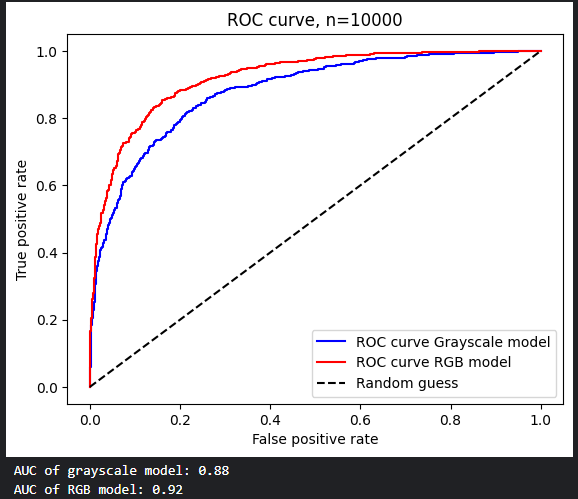

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


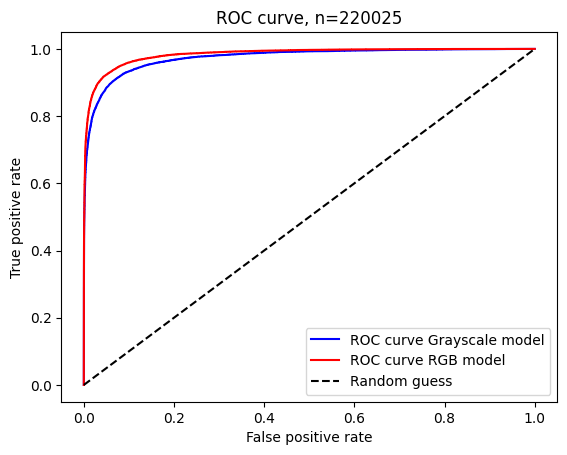

AUC of grayscale model: 0.97
AUC of RGB model: 0.98


In [11]:
y_pred_proba = model.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

y_pred_proba_o = model_original.predict(x_test_o)
fpr_o, tpr_o, thresholds_o = roc_curve(y_test_o, y_pred_proba_o)

plt.plot(fpr, tpr, label='ROC curve Grayscale model', c='blue')
plt.plot(fpr_o, tpr_o, label='ROC curve RGB model', c='red')
plt.plot([0,1], [0,1], 'k--', label='Random guess')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve, n='+str(N))
plt.legend()
plt.show()

auc = roc_auc_score(y_test, y_pred_proba)
auc_o = roc_auc_score(y_test_o, y_pred_proba_o)
print('AUC of grayscale model: %.2f' % auc)
print('AUC of RGB model: %.2f' % auc_o)

Conclusion (15 pts)

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

By just increasing the training data to the full 220,025 dataset, our Grayscale model performs almost exactly the same as the original RGB model. The accuracy scores produced by the ROC curves are 97% abd 98%, both of which are extremely stellar. It's extremely beneficial that we are able to produce a model that performs nearly the same as the original, yet it essentially uses 1/3 less of data because it converts RGB images to grayscale. This simple adaptation will free up more computer resources that could be used for increasing the dataset or making the algorithm's architecture more complex.

Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard (35 points)

These deliverables serve two purposes- grade for this course and your project portfolio that you can show when you apply for jobs.

In [12]:
# required to use .map()

def process_image(image):
    return cv2.imread(image, cv2.IMREAD_GRAYSCALE)

In [13]:
base_test_dir = test_path #specify test data folder
test_files = glob(os.path.join(base_test_dir,'*.tif')) #find the test file names
submission = pd.DataFrame() #create a dataframe to hold results
file_batch = 5000 #we will predict 5000 images at a time
max_idx = len(test_files) #last index to use
for idx in range(0, max_idx, file_batch): #iterate over test image batches
    print("Indexes: %i - %i"%(idx, idx+file_batch))
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]}) #add the filenames to the dataframe
    test_df['id'] = test_df.path.map(lambda x: x.split('/')[-1].split(".")[0]) #add the ids to the dataframe
    print(test_df['id'])
    # test_df['image'] = test_df['path'].map(cv2.imread) #read the batch
    test_df['image'] = test_df['path'].map(process_image)
    K_test = np.stack(test_df["image"].values) #convert to numpy array

    #change to model_original for RGB model, keep as model for grayscale
    predictions = model.predict(K_test,verbose = 1) #predict the labels for the test data
    test_df['label'] = predictions #store them in the dataframe
    submission = pd.concat([submission, test_df[["id", "label"]]])
submission.head() #display first lines

Indexes: 0 - 5000
0       a7ea26360815d8492433b14cd8318607bcf99d9e
1       59d21133c845dff1ebc7a0c7cf40c145ea9e9664
2       5fde41ce8c6048a5c2f38eca12d6528fa312cdbb
3       bd953a3b1db1f7041ee95ff482594c4f46c73ed0
4       523fc2efd7aba53e597ab0f69cc2cbded7a6ce62
                          ...                   
4995    11a988455f10b934332ea36e94fbd707c0c83893
4996    c7057faf8534751136b648fd8f814d47bf356caa
4997    c4e8b0ec618f253f74b3e5ecb50dbbfab50e8e9b
4998    a7b0315267ce386bb4e51d80042f8e3a310bc010
4999    be5099fb6957241378018fc153ce9de21daf4cb0
Name: id, Length: 5000, dtype: object
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Indexes: 5000 - 10000
0       d5f1dc6bbb51a55bfe14053540bf7d17e120345d
1       0f3352ff8e18965b7e1c5205096564571233f1e8
2       793da3a90adf806c5f2b3c42853ae29dc8200ac0
3       5ec848d18bba02ba6dffc5db12fd7d67b6a3ceb5
4       0141f11909795a651a1b009fb6e54a31862f1531
                          ...                   
4995    9d726148f5635070dd10a0c401ca2f8347e2ede7

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.214152
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.010206
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.013928
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.585528
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.434480


In [14]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file